# Preliminary analysis of historical NYC weather and MTA performance



## 1. Begin with checking validity of data and data types

In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load processed data
transit_df = pl.read_csv("../data/processed/mta_monthly_master_20250902.csv") 
weather_df = pl.read_csv("../data/processed/noaa_weather_monthly_20250829.csv")

print("Data loaded successfully!")
print(f"Transit data: {transit_df.shape}")
print(f"Weather data: {weather_df.shape}")

Data loaded successfully!
Transit data: (25970, 13)
Weather data: (36, 29)


In [3]:
# Look at the structure
print("=== TRANSIT DATA COLUMNS ===")
print(transit_df.columns)
print(f"\nData types:")
print(transit_df.dtypes)

print("\n=== WEATHER DATA COLUMNS ===")
print(weather_df.columns)
print(f"\nData types:")
print(weather_df.dtypes)

=== TRANSIT DATA COLUMNS ===
['month', 'route_id', 'period', 'num_passengers', 'avg_additional_stop_time', 'avg_additional_travel_time', 'customer_journey_time_performance', 'date', 'year', 'year_month', 'data_source', 'frequency', 'transit_mode']

Data types:
[Int64, String, String, Float64, Float64, Float64, Float64, String, Int64, String, String, String, String]

=== WEATHER DATA COLUMNS ===
['year_month', 'TMAX_mean', 'TMAX_max', 'TMAX_std', 'TMIN_mean', 'TMIN_min', 'TMIN_std', 'TEMP_RANGE_mean', 'TEMP_RANGE_std', 'PRCP_sum', 'PRCP_mean', 'PRCP_max', 'SNOW_sum', 'SNOW_max', 'SNWD_mean', 'SNWD_max', 'AWND_mean', 'AWND_max', 'WSF2_max', 'HEAVY_RAIN_sum', 'ANY_PRECIP_sum', 'SNOW_EVENT_sum', 'HIGH_WIND_sum', 'is_weekend_mean', 'date_min', 'date_max', 'station_first', 'frequency', 'data_source']

Data types:
[String, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Int64, Int

In [4]:
# Get basic summary stats
print("=== TRANSIT DATA SUMMARY ===")
transit_df.describe()

=== TRANSIT DATA SUMMARY ===


statistic,month,route_id,period,num_passengers,avg_additional_stop_time,avg_additional_travel_time,customer_journey_time_performance,date,year,year_month,data_source,frequency,transit_mode
str,f64,str,str,f64,f64,f64,f64,str,f64,str,str,str,str
"""count""",25970.0,"""25970""","""25970""",25970.0,25970.0,25970.0,25970.0,"""25970""",25970.0,"""25970""","""25970""","""25970""","""25970"""
"""null_count""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""0""",0.0,"""0""","""0""","""0""","""0"""
"""mean""",6.50412,null,null,238123.365802,2.960482,0.951074,0.67465,null,2023.002233,null,null,null,null
"""std""",3.453191,null,null,732357.900599,1.920746,2.879358,0.138873,null,0.816006,null,null,null,null
"""min""",1.0,"""1""","""Off-Peak""",1.5541,-5.018944,-23.611177,0.0,"""2022-01-01""",2022.0,"""2022-01""","""bus_metrics""","""monthly""","""bus"""
"""25%""",4.0,null,null,12567.721,1.7823825,0.06912,0.6080547,null,2022.0,null,null,null,null
"""50%""",7.0,null,null,55745.53,2.5271258,0.7246582,0.6904069,null,2023.0,null,null,null,null
"""75%""",10.0,null,null,116191.63,3.5911899,1.5762805,0.766285,null,2024.0,null,null,null,null
"""max""",12.0,"""X68""","""peak""",6373271.5,48.621685,20.828417,1.0,"""2024-12-01""",2024.0,"""2024-12""","""subway_metrics""","""monthly""","""subway"""


## 2. Now some basic delay pattern analysis

In [6]:
# Record delay-related columns
delay_cols = [col for col in transit_df.columns if any(term in col.lower() 
             for term in ['delay', 'additional', 'time', 'performance'])]
print("Available delay-related columns:")
for col in delay_cols:
    print(f"  {col}")

Available delay-related columns:
  avg_additional_stop_time
  avg_additional_travel_time
  customer_journey_time_performance


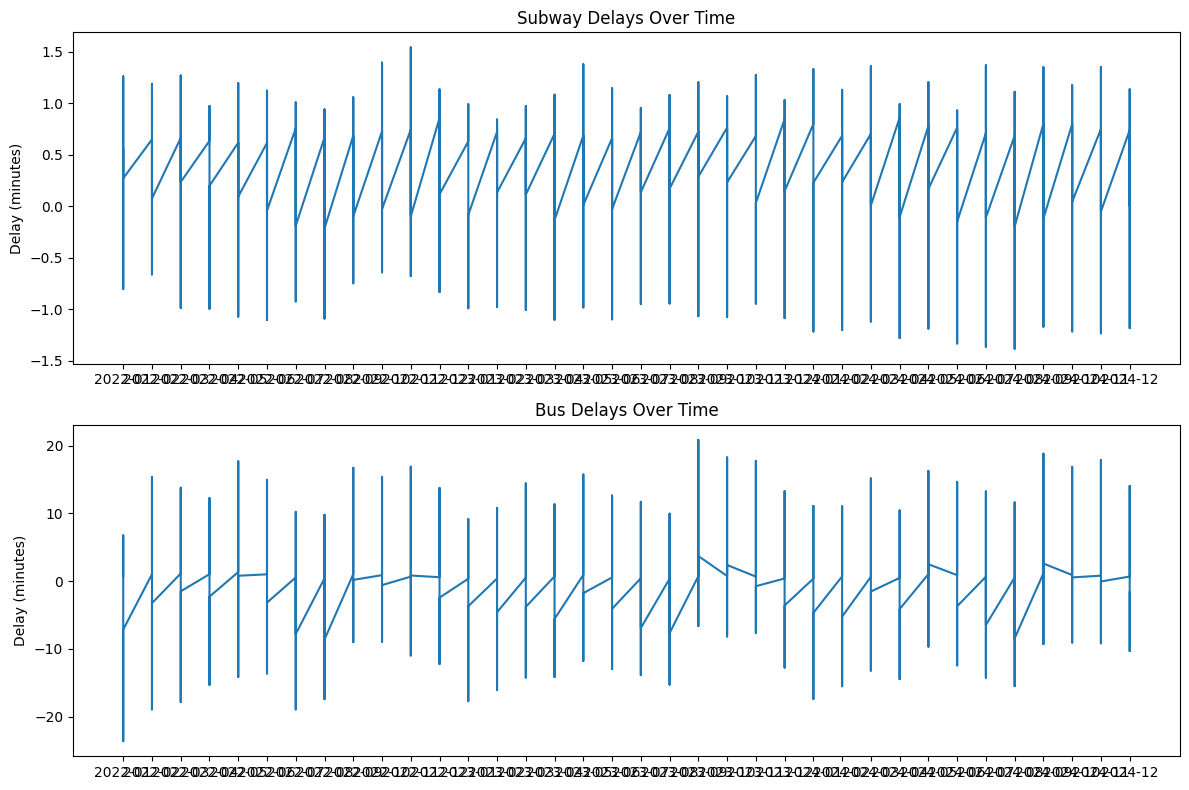

In [7]:
# Plot delays over time, separated by subway vs bus
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Filter for subway and bus data
subway_data = transit_df.filter(pl.col('transit_mode') == 'subway')
bus_data = transit_df.filter(pl.col('transit_mode') == 'bus')

# Choose main delay metric - choose from above
delay_metric = 'avg_additional_travel_time'  # Can be adjusted

# Plot subway delays
subway_plot_data = subway_data.select(['year_month', delay_metric]).sort('year_month')
axes[0].plot(subway_plot_data['year_month'], subway_plot_data[delay_metric])
axes[0].set_title('Subway Delays Over Time')
axes[0].set_ylabel('Delay (minutes)')

# Plot bus delays  
bus_plot_data = bus_data.select(['year_month', delay_metric]).sort('year_month')
axes[1].plot(bus_plot_data['year_month'], bus_plot_data[delay_metric])
axes[1].set_title('Bus Delays Over Time')
axes[1].set_ylabel('Delay (minutes)')

plt.tight_layout()
plt.show()

The only thing that pops out to me right now is the difference in scale between these graphs.

Average delays by month:
shape: (24, 3)
┌───────┬──────────────┬───────────┐
│ month ┆ transit_mode ┆ avg_delay │
│ ---   ┆ ---          ┆ ---       │
│ i64   ┆ str          ┆ f64       │
╞═══════╪══════════════╪═══════════╡
│ 1     ┆ bus          ┆ 0.040182  │
│ 2     ┆ bus          ┆ 0.56633   │
│ 3     ┆ bus          ┆ 1.041631  │
│ 4     ┆ bus          ┆ 0.598938  │
│ 5     ┆ bus          ┆ 1.860768  │
│ …     ┆ …            ┆ …         │
│ 8     ┆ subway       ┆ 0.347426  │
│ 9     ┆ subway       ┆ 0.448652  │
│ 10    ┆ subway       ┆ 0.443943  │
│ 11    ┆ subway       ┆ 0.436548  │
│ 12    ┆ subway       ┆ 0.433392  │
└───────┴──────────────┴───────────┘


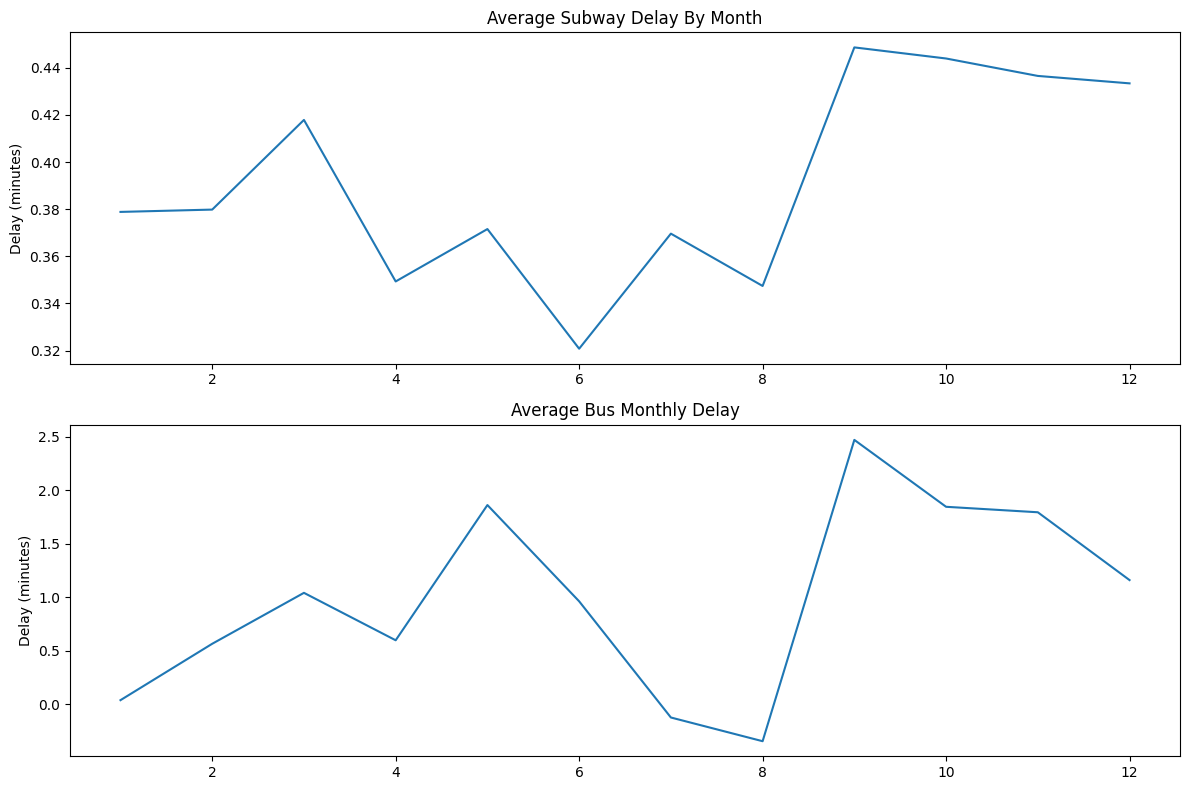

In [11]:
# Group by month to see seasonal patterns
monthly_patterns = transit_df.group_by(['month', 'transit_mode']).agg([
    pl.col(delay_metric).mean().alias('avg_delay')
])

print("Average delays by month:")
print(monthly_patterns.sort(['transit_mode', 'month']))


# Now plot delays over time, separated by subway vs bus
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Filter for subway and bus data
subway_monthly_data = monthly_patterns.filter(pl.col('transit_mode') == 'subway')
bus_monthly_data = monthly_patterns.filter(pl.col('transit_mode') == 'bus')


# Plot subway delays
subway_monthly_plot_data = subway_monthly_data.select(['month', 'avg_delay']).sort('month')
axes[0].plot(subway_monthly_plot_data['month'], subway_monthly_plot_data['avg_delay'])
axes[0].set_title('Average Subway Delay By Month')
axes[0].set_ylabel('Delay (minutes)')

# Plot bus delays  
bus_monthly_plot_data = bus_monthly_data.select(['month', 'avg_delay']).sort('month')
axes[1].plot(bus_monthly_plot_data['month'], bus_monthly_plot_data['avg_delay'])
axes[1].set_title('Average Bus Monthly Delay')
axes[1].set_ylabel('Delay (minutes)')

plt.tight_layout()
plt.show()

The delays seem to be lowest in the summer and peak in the fall. This could be weather related, though that seems somewhat unlikely. Another possibility is lower ridership due to school not being in session. 

## 3. Begin analyzing delays based on weather patterns

In [13]:
# Merge on the year_month column
merged_df = transit_df.join(weather_df, on='year_month', how='inner')  # or whatever date column works
print(f"Merged dataset shape: {merged_df.shape}")
print(merged_df)

Merged dataset shape: (25970, 41)
shape: (25_970, 41)
┌───────┬──────────┬──────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ month ┆ route_id ┆ period   ┆ num_passen ┆ … ┆ date_max   ┆ station_fi ┆ frequency_ ┆ data_sourc │
│ ---   ┆ ---      ┆ ---      ┆ gers       ┆   ┆ ---        ┆ rst        ┆ right      ┆ e_right    │
│ i64   ┆ str      ┆ str      ┆ ---        ┆   ┆ str        ┆ ---        ┆ ---        ┆ ---        │
│       ┆          ┆          ┆ f64        ┆   ┆            ┆ str        ┆ str        ┆ str        │
╞═══════╪══════════╪══════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 12    ┆ 1        ┆ offpeak  ┆ 5.03459e6  ┆ … ┆ 2024-12-31 ┆ CENTRAL_PA ┆ monthly    ┆ noaa_weath │
│       ┆          ┆          ┆            ┆   ┆            ┆ RK         ┆            ┆ er         │
│ 12    ┆ 1        ┆ peak     ┆ 5.552918e6 ┆ … ┆ 2024-12-31 ┆ CENTRAL_PA ┆ monthly    ┆ noaa_weath │
│       ┆          ┆          ┆      

Weather columns: ['TMAX_mean', 'TMAX_max', 'TMAX_std', 'TMIN_mean', 'TMIN_min', 'TMIN_std', 'TEMP_RANGE_mean', 'TEMP_RANGE_std', 'PRCP_sum', 'PRCP_mean', 'PRCP_max', 'SNOW_sum', 'SNOW_max', 'AWND_mean', 'AWND_max', 'ANY_PRECIP_sum', 'SNOW_EVENT_sum']
Delay columns: ['avg_additional_stop_time', 'avg_additional_travel_time', 'customer_journey_time_performance']


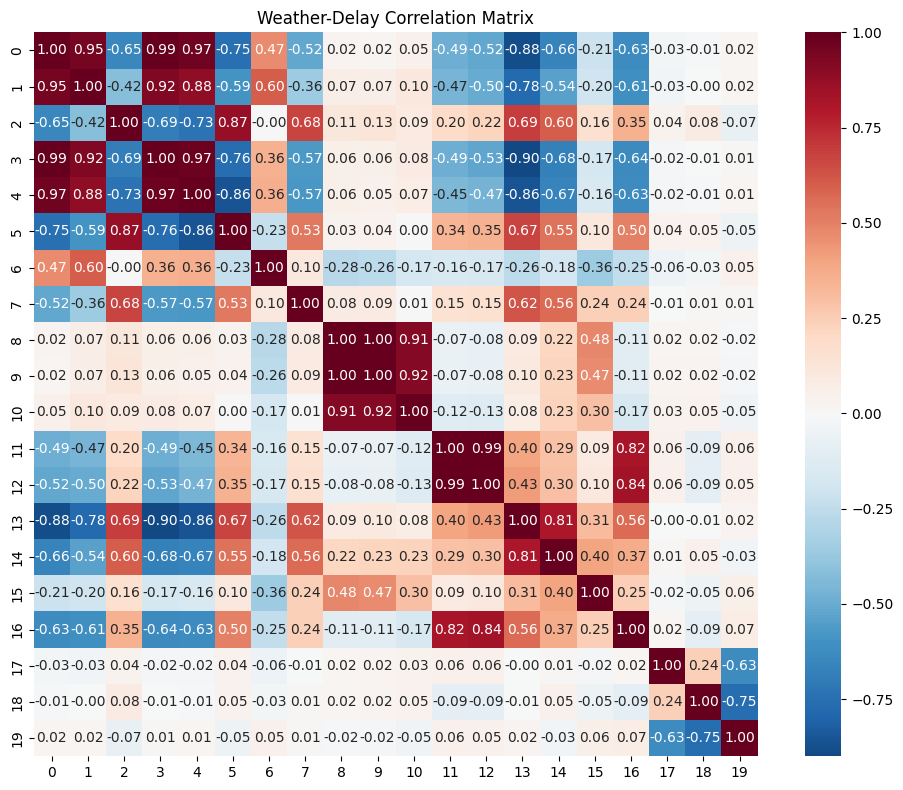

In [19]:
# Identify weather and delay columns
weather_cols = [col for col in merged_df.columns if any(term in col.lower() 
               for term in ['tmin', 'tmax', 'temp', 'prcp', 'precip', 'snow', 'precipitation', 'wnd', 'wnd', 'pressure'])]
delay_cols = [col for col in merged_df.columns if any(term in col.lower() 
             for term in ['delay', 'additional_travel_time', 'additional_stop_time','performance'])]

print("Weather columns:", weather_cols)
print("Delay columns:", delay_cols)

# Create correlation matrix
correlation_cols = weather_cols + delay_cols
corr_df = merged_df.select(correlation_cols).corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.2f')
plt.title('Weather-Delay Correlation Matrix')
plt.tight_layout()
plt.show()

The first 16 categories shown here is weather data. The last three are performance metrics from the MTA. At first glance there does not appear to be a major effect of weather on transit performance, at least in aggregate.

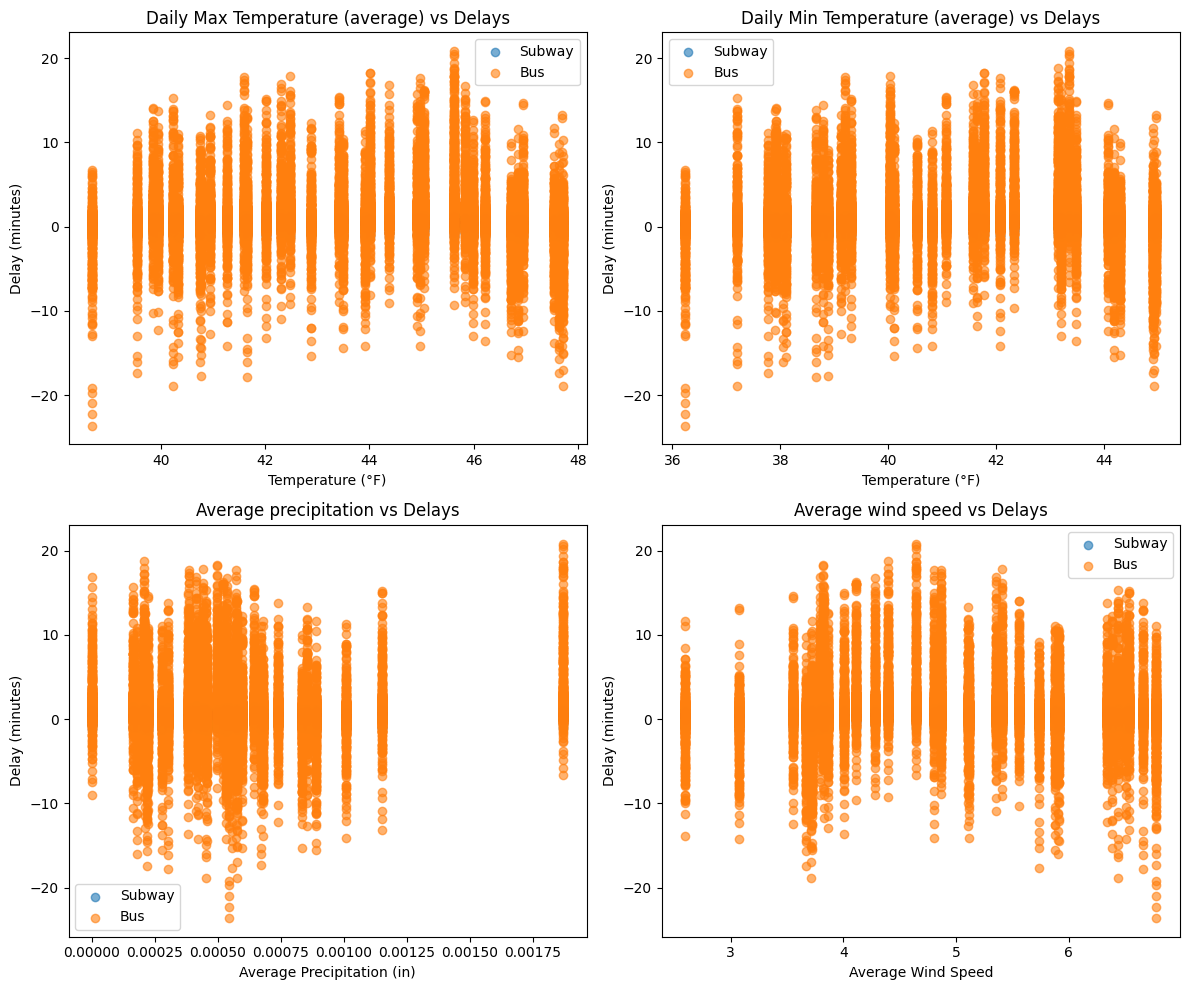

In [22]:
# Create scatter plots for key weather variables
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Temperature vs Delay (separate by transit mode)
subway_data = merged_df.filter(pl.col('transit_mode') == 'subway')
bus_data = merged_df.filter(pl.col('transit_mode') == 'bus')

# Plot delays versus average max temp
axes[0,0].scatter(subway_data['TMAX_mean'], subway_data['avg_additional_travel_time'], alpha=0.6, label='Subway')
axes[0,0].scatter(bus_data['TMAX_mean'], bus_data['avg_additional_travel_time'], alpha=0.6, label='Bus')
axes[0,0].set_xlabel('Temperature (°F)')
axes[0,0].set_ylabel('Delay (minutes)')
axes[0,0].set_title('Daily Max Temperature (average) vs Delays')
axes[0,0].legend()


# Plot delays versus average min temp
axes[0,1].scatter(subway_data['TMIN_mean'], subway_data['avg_additional_travel_time'], alpha=0.6, label='Subway')
axes[0,1].scatter(bus_data['TMIN_mean'], bus_data['avg_additional_travel_time'], alpha=0.6, label='Bus')
axes[0,1].set_xlabel('Temperature (°F)')
axes[0,1].set_ylabel('Delay (minutes)')
axes[0,1].set_title('Daily Min Temperature (average) vs Delays')
axes[0,1].legend()


# Delays vs average preciptation
axes[1,0].scatter(subway_data['PRCP_mean'], subway_data['avg_additional_travel_time'], alpha=0.6, label='Subway')
axes[1,0].scatter(bus_data['PRCP_mean'], bus_data['avg_additional_travel_time'], alpha=0.6, label='Bus')
axes[1,0].set_xlabel('Average Precipitation (in)')
axes[1,0].set_ylabel('Delay (minutes)')
axes[1,0].set_title('Average precipitation vs Delays')
axes[1,0].legend()

# Delays vs wind speed
axes[1,1].scatter(subway_data['AWND_mean'], subway_data['avg_additional_travel_time'], alpha=0.6, label='Subway')
axes[1,1].scatter(bus_data['AWND_mean'], bus_data['avg_additional_travel_time'], alpha=0.6, label='Bus')
axes[1,1].set_xlabel('Average Wind Speed')
axes[1,1].set_ylabel('Delay (minutes)')
axes[1,1].set_title('Average wind speed vs Delays')
axes[1,1].legend()


plt.tight_layout()
plt.show()

Reading the above there are problems with the collected data - the temperature in NYC certainly reached higher than 48 F. I'll need to review the data collection code.